# 1. Image preprocessing

## Load all library

In [1]:
from imutils import paths
import os
import cv2
import tensorflow as tf
import numpy as np

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.layers import (
    AveragePooling2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    ReLU,
    LeakyReLU
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras import layers



## Specify Directory

In [2]:
DATA_DIR = "/content/drive/MyDrive/dataset_4"

imagePaths = list(paths.list_images(DATA_DIR))

## Image resize and reshape



In [3]:
images = []
labels = []

for imagePath in imagePaths:
  path_parts = imagePath.split(os.path.sep)
  label = path_parts[-2]
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  images.append(image)
  labels.append(label)

In [4]:
image_data = np.array(images) / 255.0
labels_data = np.array(labels)

## One-hot encoding

In [5]:
lb = LabelBinarizer()
lb.fit(labels_data)
encoded_labels = lb.transform(labels_data)

labels_data = to_categorical(encoded_labels, num_classes = 2)

## Define callbacks

In [6]:
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# save directory for resnet50
MODEL_DIR = "/content/drive/MyDrive"
resnet_mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'resnet50_best_weights'),
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

# save directory for vgg
vgg_mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'vgg16_best_weights'),
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

# save directory for custon cnn
mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'default_best_weights'),
    save_best_only=True,
    monitor='accuracy',
    mode='max',
    verbose=1
)

# reduce lr loss
reduce_lr_loss = ReduceLROnPlateau(
    monitor='loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

## Freeze all layers

In [7]:
def fix_layers(model, num_flex_layers: int = 1):
    """
    Receives a model and freezes all layers but the last num_flex_layers ones.

    Arguments:
        model {tensorflow.python.keras.engine.training.Model} -- model

    Keyword Arguments:
        num_flex_layers {int} -- [Number of trainable layers] (default: {1})

    Returns:
        Model -- updated model
    """
    num_layers = len(model.layers)
    for ind, layer in enumerate(model.layers):
        if ind < num_layers - num_flex_layers:
            layer.trainable = False

    return model

# 2. Model Training

## Define models

In [8]:
from tensorflow.keras.models import Model
import tensorflow.keras as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import layers

# vgg16 architecture
def get_model(
    input_size: tuple = (224,224,3),
    num_classes: int = 2,
    dropout: float = 0.5,
    hidden_size: int = 64,
    trainable_layers: int = 1,
    mc_dropout: bool = False
):
  # activiation function
  act_fn = tf.nn.softmax

  # load the vgg16 network, ensuring the head full connected layer sets are left off
  baseModel = VGG16(
            weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=input_size)
        )

  # construct the head of the model that will be placed on top of the
  # the base model
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(hidden_size)(headModel)
  headModel = BatchNormalization()(headModel)
  headModel = ReLU()(headModel)
  headModel = (
      Dropout(dropout)(headModel, training=True)
      if mc_dropout else Dropout(dropout)(headModel)
  )
  headModel = Dense(num_classes, activation=act_fn)(headModel)

  # place the head full connected model on top of the base model
  model = Model(inputs=baseModel.input, outputs=headModel)

  model = fix_layers(model, num_flex_layers=trainable_layers + 8)

  return model

# resnet50 architecture

def get_resnet50_model(
    input_size: tuple = (224, 224, 3),
    hidden_size: int = 64,
    dropout: float = 0.5,
    num_classes: int = 2,
    trainable_layers: int = 3,
    log_softmax: bool = True,
    mc_dropout: bool = False,
    **kwargs
):
    act_fn = tf.nn.softmax if not log_softmax else tf.nn.log_softmax

    # load the VGG16 network, ensuring the head FC layer sets are left off
    baseModel = ResNet50(
        weights="imagenet",
        include_top=False,
        input_tensor=Input(shape=input_size)
    )
    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(hidden_size)(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = ReLU()(headModel)
    headModel = (
        Dropout(dropout)(headModel, training=True)
        if mc_dropout else Dropout(dropout)(headModel)
    )
    headModel = Dense(num_classes, activation=act_fn)(headModel)

    # place the head FC model on top of the base model
    model = Model(inputs=baseModel.input, outputs=headModel)

    model = fix_layers(model, num_flex_layers=trainable_layers + 8)

    return model

# custom cnn architecture
def get_cnn():
  # create model
  model = Sequential()

  # add model layers
  model.add(Conv2D(16, kernel_size=7, activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(AveragePooling2D(pool_size=(2, 2)))  # Replace MaxPooling2D with AveragePooling2D
  model.add(Conv2D(64, kernel_size=3, activation='relu'))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(Dense(2, activation='softmax'))  # Change units to 2 for 2 classes softmax output

  return model

def global_average_pooling(x):
  return K.backend.mean(x, axis=(1, 2))

## Initiate model

In [10]:
# custom cnn model
cnn_model = get_cnn()

In [9]:
# vgg16 model
vgg_model = get_model()

58889256/58889256 [==============================] - 2s 0us/step


In [11]:
# resnet50 model
resnet_model = get_resnet50_model()

94765736/94765736 [==============================] - 3s 0us/step


## Define stratified k-fold

In [12]:
num_folds = 3
X, y = image_data, labels_data
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


# 3. Custom CNN model training

In [17]:
LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 16

initial_learning_rate = 1e-4
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(len(image_data)/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True
    )

optimizer = Adam(learning_rate = lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()

cnn_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [18]:
# Lists to store loss and accuracy values for each fold
cnn_train_losses = []
cnn_train_accuracies = []
cnn_val_losses = []
cnn_val_accuracies = []

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# record the true label and predicted label
true_labels_list = []
predicted_labels_list = []


fold = 1
for train_idx, test_idx in skf.split(X, encoded_labels):
    print(f"Fold {fold}:")

    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'len of training samples: {len(X_train)}')
    print(f'len of testing samples: {len(y_train)}')

    cnn_model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    history = cnn_model.fit(X_train,
              y_train,
              batch_size=BATCH_SIZE,
              steps_per_epoch=len(X_train) // BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
              )

    # Evaluate the model on the test set
      # Generate generalization metrics
    scores = cnn_model.evaluate(X[test_idx], y[test_idx], verbose=0)
    print(f'Score for fold {fold}: {cnn_model.metrics_names[0]} of {scores[0]}; {cnn_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predict labels for the test set
    y_pred = cnn_model.predict(X[test_idx])

    # Convert the predicted probabilities to class labels (0 or 1)
    predicted_labels = np.argmax(y_pred, axis=1)

    # Convert the true labels back to their original form (encoded_labels -> original class labels)
    true_labels = np.argmax(y[test_idx], axis=1)

    # Append true and predicted labels for each fold
    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_labels)

    # Store training and validation loss and accuracy for this fold
    cnn_train_losses.append(history.history['loss'])
    cnn_train_accuracies.append(history.history['accuracy'])
    cnn_val_losses.append(history.history['val_loss'])
    cnn_val_accuracies.append(history.history['val_accuracy'])

    fold += 1

report = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:")
print(report)

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



Fold 1:
len of training samples: 286
len of testing samples: 286
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5809
Epoch 1: accuracy improved from -inf to 0.58088, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 8s 173ms/step - loss: 0.6864 - accuracy: 0.5809 - val_loss: 0.6806 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/30
15/17 [=========================>....] - ETA: 0s - loss: 0.6865 - accuracy: 0.5546
Epoch 2: accuracy did not improve from 0.58088
17/17 [==============================] - 1s 31ms/step - loss: 0.6860 - accuracy: 0.5556 - val_loss: 0.6770 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 3/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6758 - accuracy: 0.5906
Epoch 3: accuracy did not improve from 0.58088
17/17 [==============================] - 1s 30ms/step - loss: 0.6799 - accuracy: 0.5778 - val_loss: 0.6740 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 4/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6721 - accuracy: 0.6024
Epoch 4: accuracy improved from 0.58088 to 0.58519, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 122ms/step - loss: 0.6774 - accuracy: 0.5852 - val_loss: 0.6715 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 5/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6623 - accuracy: 0.5984
Epoch 5: accuracy improved from 0.58519 to 0.59630, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 120ms/step - loss: 0.6632 - accuracy: 0.5963 - val_loss: 0.6673 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 6/30
15/17 [=========================>....] - ETA: 0s - loss: 0.6689 - accuracy: 0.5924
Epoch 6: accuracy did not improve from 0.59630
17/17 [==============================] - 1s 30ms/step - loss: 0.6699 - accuracy: 0.5889 - val_loss: 0.6633 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 7/30
15/17 [=========================>....] - ETA: 0s - loss: 0.6672 - accuracy: 0.6008
Epoch 7: accuracy did not improve from 0.59630
17/17 [==============================] - 0s 30ms/step - loss: 0.6696 - accuracy: 0.5963 - val_loss: 0.6598 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 8/30
15/17 [=========================>....] - ETA: 0s - loss: 0.6774 - accuracy: 0.5714
Epoch 8: accuracy did not improve from 0.59630
17/17 [==============================] - 1s 31ms/step - loss: 0.6770 - accuracy: 0.5667 - val_loss: 0.6601 - val_accuracy: 0.5833 - lr:

17/17 [==============================] - 2s 142ms/step - loss: 0.6402 - accuracy: 0.6037 - val_loss: 0.6267 - val_accuracy: 0.5972 - lr: 1.0000e-04
Epoch 11/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6283 - accuracy: 0.6102
Epoch 11: accuracy improved from 0.60370 to 0.61111, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 128ms/step - loss: 0.6280 - accuracy: 0.6111 - val_loss: 0.6170 - val_accuracy: 0.5903 - lr: 1.0000e-04
Epoch 12/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6374 - accuracy: 0.5906
Epoch 12: accuracy did not improve from 0.61111
17/17 [==============================] - 0s 29ms/step - loss: 0.6386 - accuracy: 0.5889 - val_loss: 0.6267 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 13/30
16/17 [===========================>..] - ETA: 0s - loss: 0.6172 - accuracy: 0.6417
Epoch 13: accuracy improved from 0.61111 to 0.64815, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 121ms/step - loss: 0.6166 - accuracy: 0.6481 - val_loss: 0.5920 - val_accuracy: 0.6806 - lr: 1.0000e-04
Epoch 14/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5673 - accuracy: 0.6890
Epoch 14: accuracy improved from 0.64815 to 0.69259, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 119ms/step - loss: 0.5652 - accuracy: 0.6926 - val_loss: 0.5735 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 15/30
15/17 [=========================>....] - ETA: 0s - loss: 0.5955 - accuracy: 0.6807
Epoch 15: accuracy improved from 0.69259 to 0.70000, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 142ms/step - loss: 0.5867 - accuracy: 0.7000 - val_loss: 0.5581 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 16/30
15/17 [=========================>....] - ETA: 0s - loss: 0.5559 - accuracy: 0.6723
Epoch 16: accuracy did not improve from 0.70000
17/17 [==============================] - 1s 34ms/step - loss: 0.5530 - accuracy: 0.6815 - val_loss: 0.5559 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 17/30
17/17 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.7037
Epoch 17: accuracy improved from 0.70000 to 0.70370, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 120ms/step - loss: 0.5540 - accuracy: 0.7037 - val_loss: 0.5552 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 18/30
15/17 [=========================>....] - ETA: 0s - loss: 0.5424 - accuracy: 0.7417
Epoch 18: accuracy improved from 0.70370 to 0.74444, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 145ms/step - loss: 0.5357 - accuracy: 0.7444 - val_loss: 0.5373 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 19/30
15/17 [=========================>....] - ETA: 0s - loss: 0.5118 - accuracy: 0.7333
Epoch 19: accuracy did not improve from 0.74444
17/17 [==============================] - 1s 35ms/step - loss: 0.5134 - accuracy: 0.7316 - val_loss: 0.5298 - val_accuracy: 0.6944 - lr: 1.0000e-04
Epoch 20/30
17/17 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7222
Epoch 20: accuracy did not improve from 0.74444
17/17 [==============================] - 1s 30ms/step - loss: 0.5324 - accuracy: 0.7222 - val_loss: 0.5458 - val_accuracy: 0.7292 - lr: 1.0000e-04
Epoch 21/30
15/17 [=========================>....] - ETA: 0s - loss: 0.5196 - accuracy: 0.7185
Epoch 21: accuracy did not improve from 0.74444
17/17 [==============================] - 1s 30ms/step - loss: 0.5242 - accuracy: 0.7148 - val_loss: 0.5442 - val_accuracy: 0.7361

17/17 [==============================] - 2s 121ms/step - loss: 0.4952 - accuracy: 0.7704 - val_loss: 0.5270 - val_accuracy: 0.6806 - lr: 1.0000e-04
Epoch 25/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5403 - accuracy: 0.6811
Epoch 25: accuracy did not improve from 0.77037
17/17 [==============================] - 1s 30ms/step - loss: 0.5323 - accuracy: 0.6778 - val_loss: 0.5667 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 26/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4732 - accuracy: 0.7441
Epoch 26: accuracy did not improve from 0.77037
17/17 [==============================] - 1s 31ms/step - loss: 0.4807 - accuracy: 0.7407 - val_loss: 0.5260 - val_accuracy: 0.6944 - lr: 1.0000e-04
Epoch 27/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5272 - accuracy: 0.7008
Epoch 27: accuracy did not improve from 0.77037
17/17 [==============================] - 1s 30ms/step - loss: 0.5217 - accuracy: 0.7000 - val_loss: 0.5036 - val_accuracy: 0.7014

17/17 [==============================] - 2s 147ms/step - loss: 0.4805 - accuracy: 0.7741 - val_loss: 0.4936 - val_accuracy: 0.7153 - lr: 1.0000e-04
Score for fold 1: loss of 0.49358993768692017; accuracy of 71.52777910232544%
5/5 [==============================] - 0s 11ms/step
Fold 2:
len of training samples: 287
len of testing samples: 287
Epoch 1/30
16/17 [===========================>..] - ETA: 0s - loss: 0.5026 - accuracy: 0.7070
Epoch 1: accuracy did not improve from 0.77407
17/17 [==============================] - 2s 70ms/step - loss: 0.5084 - accuracy: 0.7059 - val_loss: 0.4932 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.7528
Epoch 2: accuracy did not improve from 0.77407
17/17 [==============================] - 1s 31ms/step - loss: 0.4739 - accuracy: 0.7528 - val_loss: 0.4828 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.4538 - accu

17/17 [==============================] - 2s 122ms/step - loss: 0.4452 - accuracy: 0.7897 - val_loss: 0.4802 - val_accuracy: 0.7483 - lr: 1.0000e-04
Epoch 6/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4885 - accuracy: 0.7333
Epoch 6: accuracy did not improve from 0.78967
17/17 [==============================] - 1s 31ms/step - loss: 0.4837 - accuracy: 0.7417 - val_loss: 0.4651 - val_accuracy: 0.7622 - lr: 1.0000e-04
Epoch 7/30
17/17 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.7823
Epoch 7: accuracy did not improve from 0.78967
17/17 [==============================] - 1s 32ms/step - loss: 0.4580 - accuracy: 0.7823 - val_loss: 0.4633 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 8/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4762 - accuracy: 0.7843
Epoch 8: accuracy did not improve from 0.78967
17/17 [==============================] - 1s 30ms/step - loss: 0.4764 - accuracy: 0.7823 - val_loss: 0.4529 - val_accuracy: 0.7692 - lr:

17/17 [==============================] - 2s 128ms/step - loss: 0.3939 - accuracy: 0.8007 - val_loss: 0.4643 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 17/30
17/17 [==============================] - ETA: 0s - loss: 0.4217 - accuracy: 0.7749
Epoch 17: accuracy did not improve from 0.80074
17/17 [==============================] - 1s 33ms/step - loss: 0.4217 - accuracy: 0.7749 - val_loss: 0.4536 - val_accuracy: 0.7832 - lr: 1.0000e-04
Epoch 18/30
17/17 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.7934
Epoch 18: accuracy did not improve from 0.80074
17/17 [==============================] - 1s 32ms/step - loss: 0.4304 - accuracy: 0.7934 - val_loss: 0.4361 - val_accuracy: 0.7832 - lr: 1.0000e-04
Epoch 19/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4180 - accuracy: 0.8008
Epoch 19: accuracy improved from 0.80074 to 0.80515, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 124ms/step - loss: 0.4210 - accuracy: 0.8051 - val_loss: 0.5100 - val_accuracy: 0.7552 - lr: 1.0000e-04
Epoch 20/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4531 - accuracy: 0.7451
Epoch 20: accuracy did not improve from 0.80515
17/17 [==============================] - 1s 31ms/step - loss: 0.4518 - accuracy: 0.7417 - val_loss: 0.4503 - val_accuracy: 0.7692 - lr: 1.0000e-04
Epoch 21/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4159 - accuracy: 0.8353
Epoch 21: accuracy improved from 0.80515 to 0.84502, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 143ms/step - loss: 0.4095 - accuracy: 0.8450 - val_loss: 0.4793 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 22/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4113 - accuracy: 0.8275
Epoch 22: accuracy did not improve from 0.84502
17/17 [==============================] - 1s 35ms/step - loss: 0.4140 - accuracy: 0.8303 - val_loss: 0.4343 - val_accuracy: 0.7972 - lr: 1.0000e-04
Epoch 23/30
17/17 [==============================] - ETA: 0s - loss: 0.4189 - accuracy: 0.7970
Epoch 23: accuracy did not improve from 0.84502

Epoch 23: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
17/17 [==============================] - 1s 32ms/step - loss: 0.4189 - accuracy: 0.7970 - val_loss: 0.4682 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 24/30
16/17 [===========================>..] - ETA: 0s - loss: 0.4021 - accuracy: 0.8118
Epoch 24: accuracy did not improve from 0.84502
17/17 [==============================] - 1s 32ms/st

17/17 [==============================] - 2s 123ms/step - loss: 0.3600 - accuracy: 0.8487 - val_loss: 0.3624 - val_accuracy: 0.8322 - lr: 1.0000e-04
Epoch 21/30
17/17 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8339
Epoch 21: accuracy did not improve from 0.84871
17/17 [==============================] - 1s 33ms/step - loss: 0.3767 - accuracy: 0.8339 - val_loss: 0.3724 - val_accuracy: 0.8322 - lr: 1.0000e-04
Epoch 22/30
16/17 [===========================>..] - ETA: 0s - loss: 0.3740 - accuracy: 0.8431
Epoch 22: accuracy did not improve from 0.84871
17/17 [==============================] - 1s 33ms/step - loss: 0.3779 - accuracy: 0.8376 - val_loss: 0.3866 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 23/30
16/17 [===========================>..] - ETA: 0s - loss: 0.3727 - accuracy: 0.8549
Epoch 23: accuracy improved from 0.84871 to 0.85240, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 126ms/step - loss: 0.3757 - accuracy: 0.8524 - val_loss: 0.3546 - val_accuracy: 0.8531 - lr: 1.0000e-04
Epoch 24/30
17/17 [==============================] - ETA: 0s - loss: 0.3625 - accuracy: 0.8561
Epoch 24: accuracy improved from 0.85240 to 0.85609, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 123ms/step - loss: 0.3625 - accuracy: 0.8561 - val_loss: 0.3589 - val_accuracy: 0.8462 - lr: 1.0000e-04
Epoch 25/30
17/17 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8413
Epoch 25: accuracy did not improve from 0.85609
17/17 [==============================] - 1s 32ms/step - loss: 0.3607 - accuracy: 0.8413 - val_loss: 0.3801 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 26/30
16/17 [===========================>..] - ETA: 0s - loss: 0.3864 - accuracy: 0.8353
Epoch 26: accuracy did not improve from 0.85609
17/17 [==============================] - 1s 31ms/step - loss: 0.3840 - accuracy: 0.8376 - val_loss: 0.3994 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 27/30
17/17 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8266
Epoch 27: accuracy did not improve from 0.85609

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
17/17 [==============================] - 1s 33ms/st

17/17 [==============================] - 2s 140ms/step - loss: 0.3437 - accuracy: 0.8598 - val_loss: 0.3727 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 29/30
17/17 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.8303
Epoch 29: accuracy did not improve from 0.85978
17/17 [==============================] - 1s 37ms/step - loss: 0.3789 - accuracy: 0.8303 - val_loss: 0.3614 - val_accuracy: 0.8392 - lr: 1.0000e-04
Epoch 30/30
16/17 [===========================>..] - ETA: 0s - loss: 0.3466 - accuracy: 0.8588
Epoch 30: accuracy improved from 0.85978 to 0.86347, saving model to /content/drive/MyDrive/default_best_weights


17/17 [==============================] - 2s 125ms/step - loss: 0.3424 - accuracy: 0.8635 - val_loss: 0.3696 - val_accuracy: 0.8252 - lr: 1.0000e-04
Score for fold 3: loss of 0.36959654092788696; accuracy of 82.51748085021973%
5/5 [==============================] - 0s 17ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       180
           1       0.81      0.79      0.80       250

    accuracy                           0.77       430
   macro avg       0.77      0.77      0.77       430
weighted avg       0.77      0.77      0.77       430

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.49358993768692017 - Accuracy: 71.52777910232544%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.464313268661499 - Accuracy: 77.62237787246704%
----

# 4. VGG16 Model Training

In [7]:
LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 16

initial_learning_rate = 1e-4
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(len(image_data)/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True
    )

optimizer = Adam(learning_rate = lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()

vgg_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# print(f'Model has {model.count_params()} parameters')
# print(f'Model summary {model.summary()}')

NameError: ignored

In [20]:
# Lists to store loss and accuracy values for each fold
vgg_train_losses = []
vgg_train_accuracies = []
vgg_val_losses = []
vgg_val_accuracies = []

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# record the true label and predicted label
true_labels_list = []
predicted_labels_list = []


fold = 1
for train_idx, test_idx in skf.split(X, encoded_labels):
    print(f"Fold {fold}:")

    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'len of training samples: {len(X_train)}')
    print(f'len of testing samples: {len(y_train)}')

    vgg_model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    history = vgg_model.fit(X_train,
              y_train,
              batch_size=BATCH_SIZE,
              steps_per_epoch=len(X_train) // BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping, vgg_mcp_save, reduce_lr_loss]
              )

    # Evaluate the model on the test set
      # Generate generalization metrics
    scores = vgg_model.evaluate(X[test_idx], y[test_idx], verbose=0)
    print(f'Score for fold {fold}: {vgg_model.metrics_names[0]} of {scores[0]}; {vgg_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predict labels for the test set
    y_pred = vgg_model.predict(X[test_idx])

    # Convert the predicted probabilities to class labels (0 or 1)
    predicted_labels = np.argmax(y_pred, axis=1)

    # Convert the true labels back to their original form (encoded_labels -> original class labels)
    true_labels = np.argmax(y[test_idx], axis=1)

    # Append true and predicted labels for each fold
    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_labels)

    # Store training and validation loss and accuracy for this fold
    vgg_train_losses.append(history.history['loss'])
    vgg_train_accuracies.append(history.history['accuracy'])
    vgg_val_losses.append(history.history['val_loss'])
    vgg_val_accuracies.append(history.history['val_accuracy'])

    fold += 1

report = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:")
print(report)

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



Fold 1:
len of training samples: 286
len of testing samples: 286
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.6765
Epoch 1: accuracy improved from -inf to 0.67647, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 10s 333ms/step - loss: 0.6508 - accuracy: 0.6765 - val_loss: 0.6884 - val_accuracy: 0.4444 - lr: 1.0000e-04
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.8148
Epoch 2: accuracy improved from 0.67647 to 0.81481, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 7s 286ms/step - loss: 0.4012 - accuracy: 0.8148 - val_loss: 0.6626 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8370
Epoch 3: accuracy improved from 0.81481 to 0.83704, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 283ms/step - loss: 0.3449 - accuracy: 0.8370 - val_loss: 0.6503 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8704
Epoch 4: accuracy improved from 0.83704 to 0.87037, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 314ms/step - loss: 0.3081 - accuracy: 0.8704 - val_loss: 0.5972 - val_accuracy: 0.6528 - lr: 1.0000e-04
Epoch 5/30
17/17 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9222
Epoch 5: accuracy improved from 0.87037 to 0.92222, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 284ms/step - loss: 0.2168 - accuracy: 0.9222 - val_loss: 0.5410 - val_accuracy: 0.8056 - lr: 1.0000e-04
Epoch 6/30
17/17 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9259
Epoch 6: accuracy improved from 0.92222 to 0.92593, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 307ms/step - loss: 0.2427 - accuracy: 0.9259 - val_loss: 0.5514 - val_accuracy: 0.7639 - lr: 1.0000e-04
Epoch 7/30
17/17 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9111
Epoch 7: accuracy did not improve from 0.92593
17/17 [==============================] - 2s 111ms/step - loss: 0.2073 - accuracy: 0.9111 - val_loss: 0.4895 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 8/30
17/17 [==============================] - ETA: 0s - loss: 0.1660 - accuracy: 0.9519
Epoch 8: accuracy improved from 0.92593 to 0.95185, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 282ms/step - loss: 0.1660 - accuracy: 0.9519 - val_loss: 0.5296 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 9/30
17/17 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9519
Epoch 9: accuracy did not improve from 0.95185
17/17 [==============================] - 2s 110ms/step - loss: 0.1542 - accuracy: 0.9519 - val_loss: 0.4664 - val_accuracy: 0.8472 - lr: 1.0000e-04
Epoch 10/30
17/17 [==============================] - ETA: 0s - loss: 0.1379 - accuracy: 0.9630
Epoch 10: accuracy improved from 0.95185 to 0.96296, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 281ms/step - loss: 0.1379 - accuracy: 0.9630 - val_loss: 0.4540 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 11/30
17/17 [==============================] - ETA: 0s - loss: 0.1174 - accuracy: 0.9704
Epoch 11: accuracy improved from 0.96296 to 0.97037, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 310ms/step - loss: 0.1174 - accuracy: 0.9704 - val_loss: 0.4570 - val_accuracy: 0.8403 - lr: 1.0000e-04
Epoch 12/30
17/17 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9926
Epoch 12: accuracy improved from 0.97037 to 0.99259, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 287ms/step - loss: 0.0982 - accuracy: 0.9926 - val_loss: 0.4265 - val_accuracy: 0.8681 - lr: 1.0000e-04
Epoch 13/30
17/17 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9704
Epoch 13: accuracy did not improve from 0.99259
17/17 [==============================] - 2s 109ms/step - loss: 0.1142 - accuracy: 0.9704 - val_loss: 0.4003 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 14/30
17/17 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9815
Epoch 14: accuracy did not improve from 0.99259
17/17 [==============================] - 2s 105ms/step - loss: 0.1114 - accuracy: 0.9815 - val_loss: 0.3617 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 15/30
17/17 [==============================] - ETA: 0s - loss: 0.1054 - accuracy: 0.9741
Epoch 15: accuracy did not improve from 0.99259
17/17 [==============================] - 2s 110ms/step - loss: 0.1054 - accuracy: 0.9741 - val_loss: 0.3321 - val_accuracy: 0.8

17/17 [==============================] - 5s 312ms/step - loss: 0.0617 - accuracy: 0.9963 - val_loss: 0.3236 - val_accuracy: 0.9028 - lr: 1.0000e-04
Epoch 19/30
17/17 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9926
Epoch 19: accuracy did not improve from 0.99630
17/17 [==============================] - 2s 110ms/step - loss: 0.0693 - accuracy: 0.9926 - val_loss: 0.3243 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 20/30
17/17 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 1.0000
Epoch 20: accuracy improved from 0.99630 to 1.00000, saving model to /content/drive/MyDrive/vgg16_best_weights


17/17 [==============================] - 5s 293ms/step - loss: 0.0555 - accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 21/30
17/17 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 1.0000
Epoch 21: accuracy did not improve from 1.00000
17/17 [==============================] - 2s 111ms/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 22/30
17/17 [==============================] - ETA: 0s - loss: 0.1231 - accuracy: 0.9741
Epoch 22: accuracy did not improve from 1.00000
17/17 [==============================] - 2s 107ms/step - loss: 0.1231 - accuracy: 0.9741 - val_loss: 0.5884 - val_accuracy: 0.6528 - lr: 1.0000e-04
Epoch 23/30
17/17 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9815
Epoch 23: accuracy did not improve from 1.00000
17/17 [==============================] - 2s 108ms/step - loss: 0.0938 - accuracy: 0.9815 - val_loss: 0.2800 - val_accuracy: 0.9

# 5. Resnet50 Model training

In [21]:
LR = 1e-4
EPOCHS = 30
BATCH_SIZE = 16

initial_learning_rate = 1e-4
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(len(image_data)/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True
    )

optimizer = Adam(learning_rate = lr_schedule)
loss = tf.keras.losses.BinaryCrossentropy()

resnet_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [22]:

# Lists to store loss and accuracy values for each fold
resnet_train_losses = []
resnet_train_accuracies = []
resnet_val_losses = []
resnet_val_accuracies = []

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# record the true label and predicted label
true_labels_list = []
predicted_labels_list = []


fold = 1
for train_idx, test_idx in skf.split(X, encoded_labels):
    print(f"Fold {fold}:")

    X_train, X_val = X[train_idx], X[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]
    print(f'len of training samples: {len(X_train)}')
    print(f'len of testing samples: {len(y_train)}')

    resnet_model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model
    history = resnet_model.fit(X_train,
              y_train,
              batch_size=BATCH_SIZE,
              steps_per_epoch=len(X_train) // BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_val, y_val),
              callbacks=[earlyStopping, resnet_mcp_save, reduce_lr_loss]
              )

    # Evaluate the model on the test set
      # Generate generalization metrics
    scores = resnet_model.evaluate(X[test_idx], y[test_idx], verbose=0)
    print(f'Score for fold {fold}: {resnet_model.metrics_names[0]} of {scores[0]}; {resnet_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predict labels for the test set
    y_pred = resnet_model.predict(X[test_idx])

    # Convert the predicted probabilities to class labels (0 or 1)
    predicted_labels = np.argmax(y_pred, axis=1)

    # Convert the true labels back to their original form (encoded_labels -> original class labels)
    true_labels = np.argmax(y[test_idx], axis=1)

    # Append true and predicted labels for each fold
    true_labels_list.extend(true_labels)
    predicted_labels_list.extend(predicted_labels)

    # Store training and validation loss and accuracy for this fold
    resnet_train_losses.append(history.history['loss'])
    resnet_train_accuracies.append(history.history['accuracy'])
    resnet_val_losses.append(history.history['val_loss'])
    resnet_val_accuracies.append(history.history['val_accuracy'])

    fold += 1

report = classification_report(true_labels_list, predicted_labels_list)
print("Classification Report:")
print(report)

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



Fold 1:
len of training samples: 286
len of testing samples: 286
Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 7.7125 - accuracy: 0.5294
Epoch 1: accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/resnet50_best_weights


17/17 [==============================] - 30s 1s/step - loss: 7.7125 - accuracy: 0.5294 - val_loss: 7.7125 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 7.7125 - accuracy: 0.4741
Epoch 2: accuracy did not improve from 0.52941
17/17 [==============================] - 2s 89ms/step - loss: 7.7125 - accuracy: 0.4741 - val_loss: 7.7125 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 7.7125 - accuracy: 0.4815
Epoch 3: accuracy did not improve from 0.52941
17/17 [==============================] - 1s 80ms/step - loss: 7.7125 - accuracy: 0.4815 - val_loss: 7.7125 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 4/30
17/17 [==============================] - ETA: 0s - loss: 7.7125 - accuracy: 0.5185
Epoch 4: accuracy did not improve from 0.52941
17/17 [==============================] - 1s 79ms/step - loss: 7.7125 - accuracy: 0.5185 - val_loss: 7.7125 - val_accuracy: 0.5833 - lr: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6. Performance

## Plot training/validationg loss

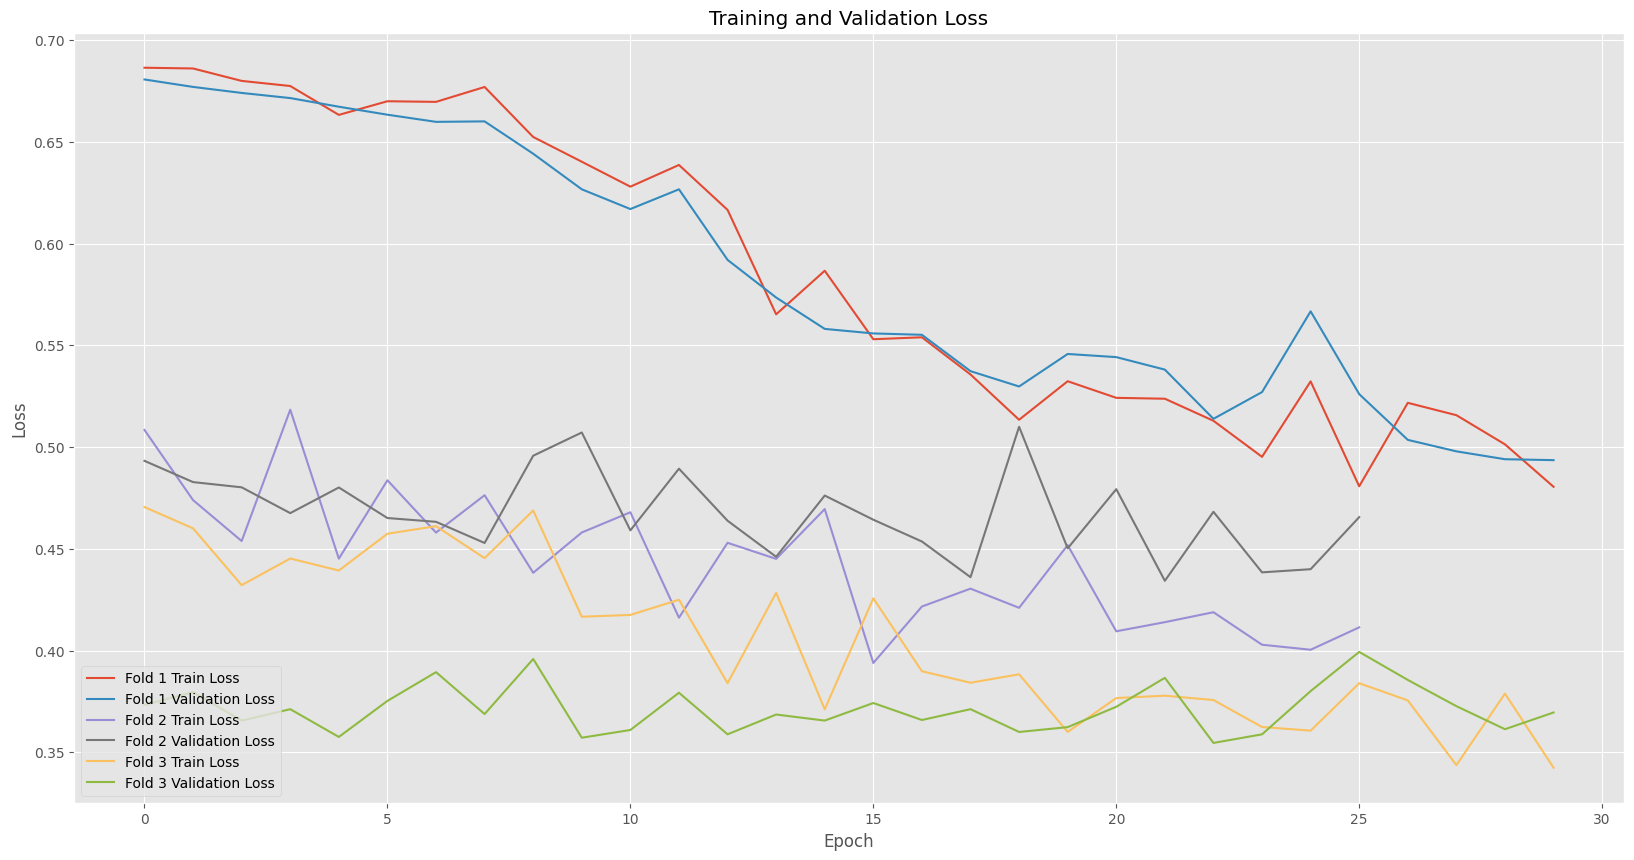

In [23]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(cnn_train_losses[fold-1], label=f'Fold {fold} Train Loss')
    plt.plot(cnn_val_losses[fold-1], label=f'Fold {fold} Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='lower left')
plt.show()

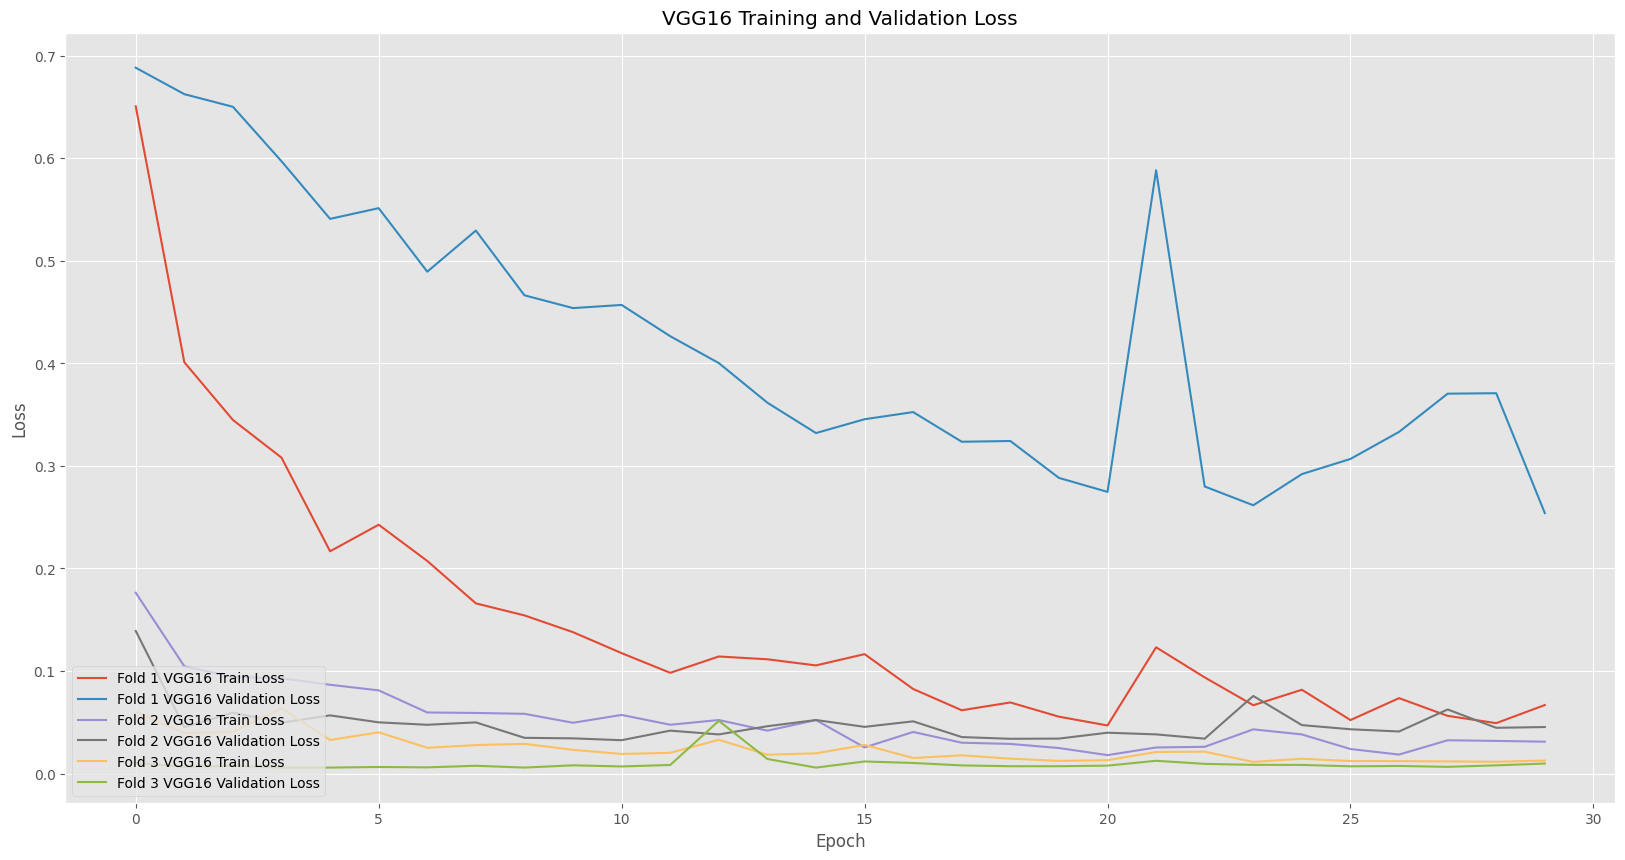

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(vgg_train_losses[fold-1], label=f'Fold {fold} VGG16 Train Loss')
    plt.plot(vgg_val_losses[fold-1], label=f'Fold {fold} VGG16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Training and Validation Loss')
plt.legend(loc='lower left')
plt.show()

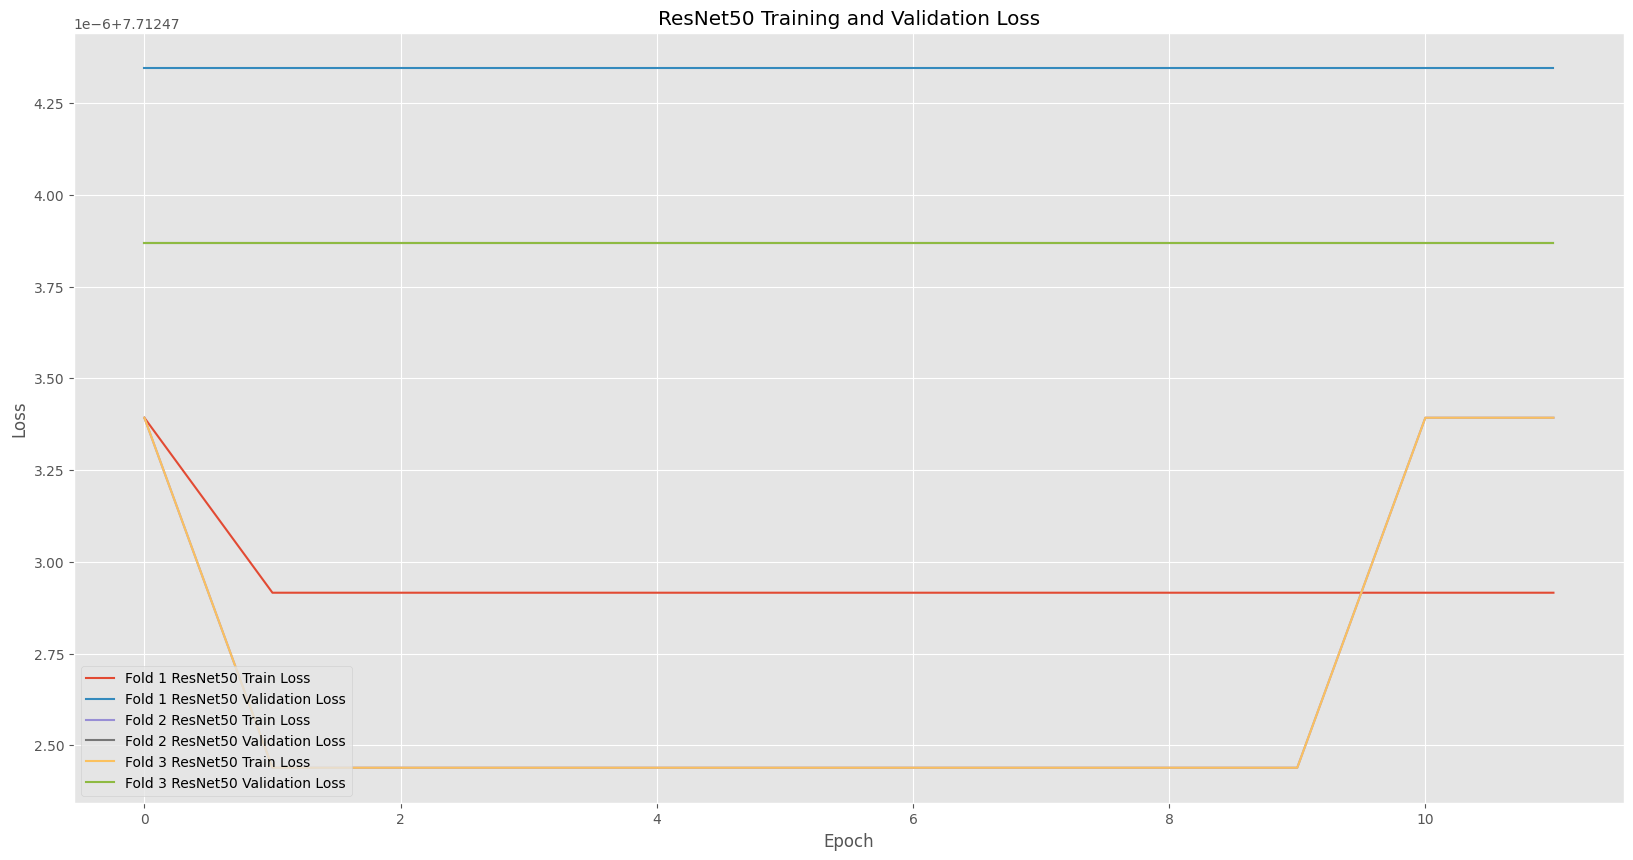

In [25]:
import matplotlib.pyplot as plt

# Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(resnet_train_losses[fold-1], label=f'Fold {fold} ResNet50 Train Loss')
    plt.plot(resnet_val_losses[fold-1], label=f'Fold {fold} ResNet50 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Training and Validation Loss')
plt.legend(loc='lower left')
plt.show()

## Plot training/validation accuracy

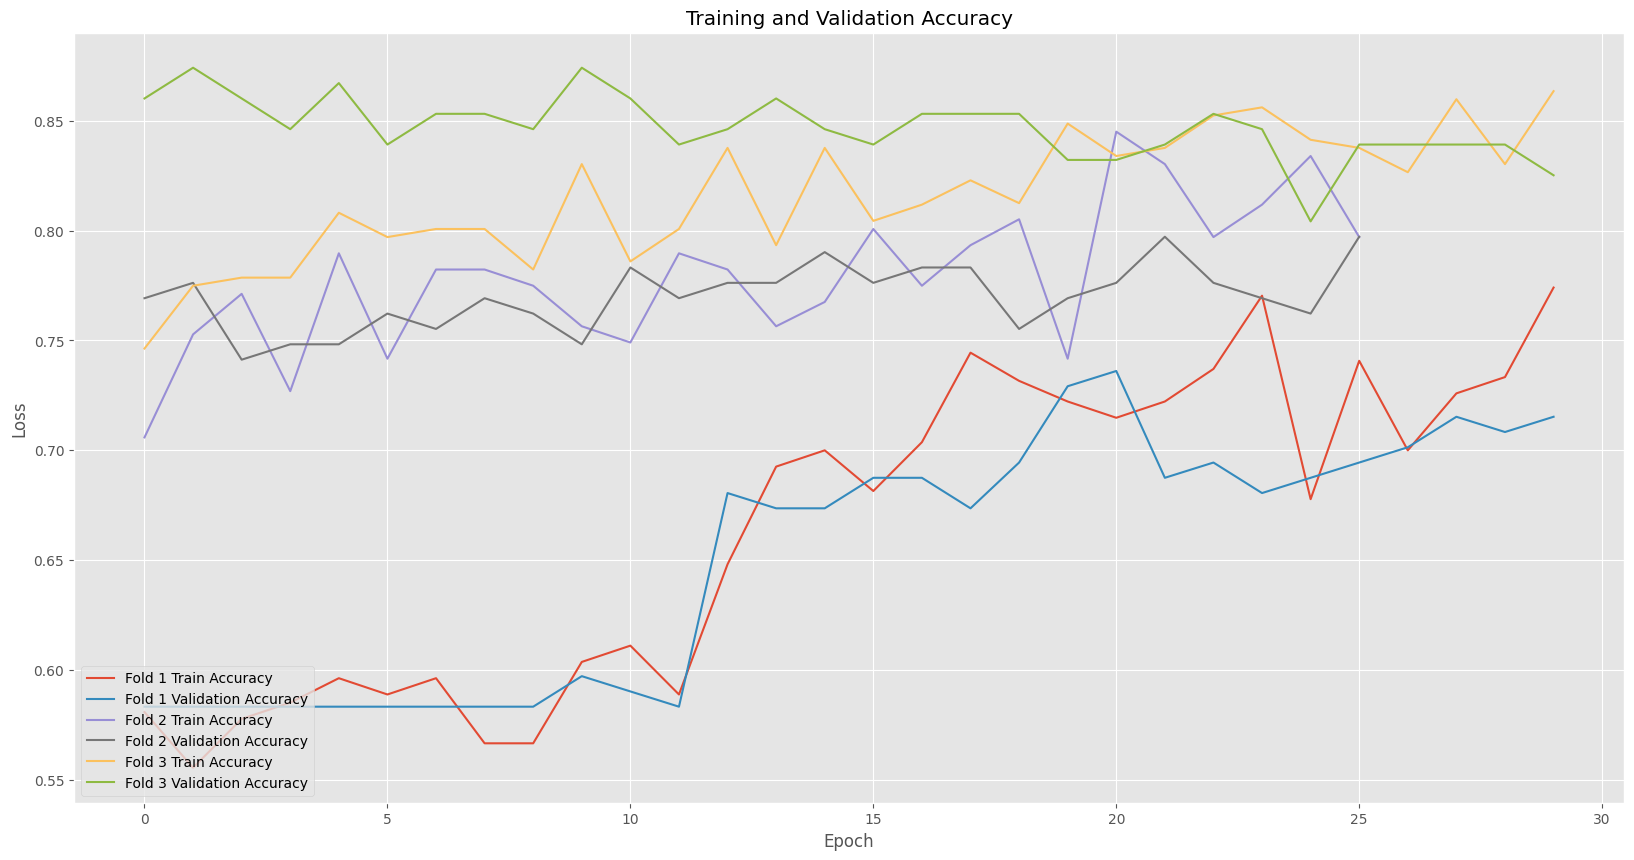

In [26]:
  # Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(cnn_train_accuracies[fold-1], label=f'Fold {fold} Train Accuracy')
    plt.plot(cnn_val_accuracies[fold-1], label=f'Fold {fold} Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.show()

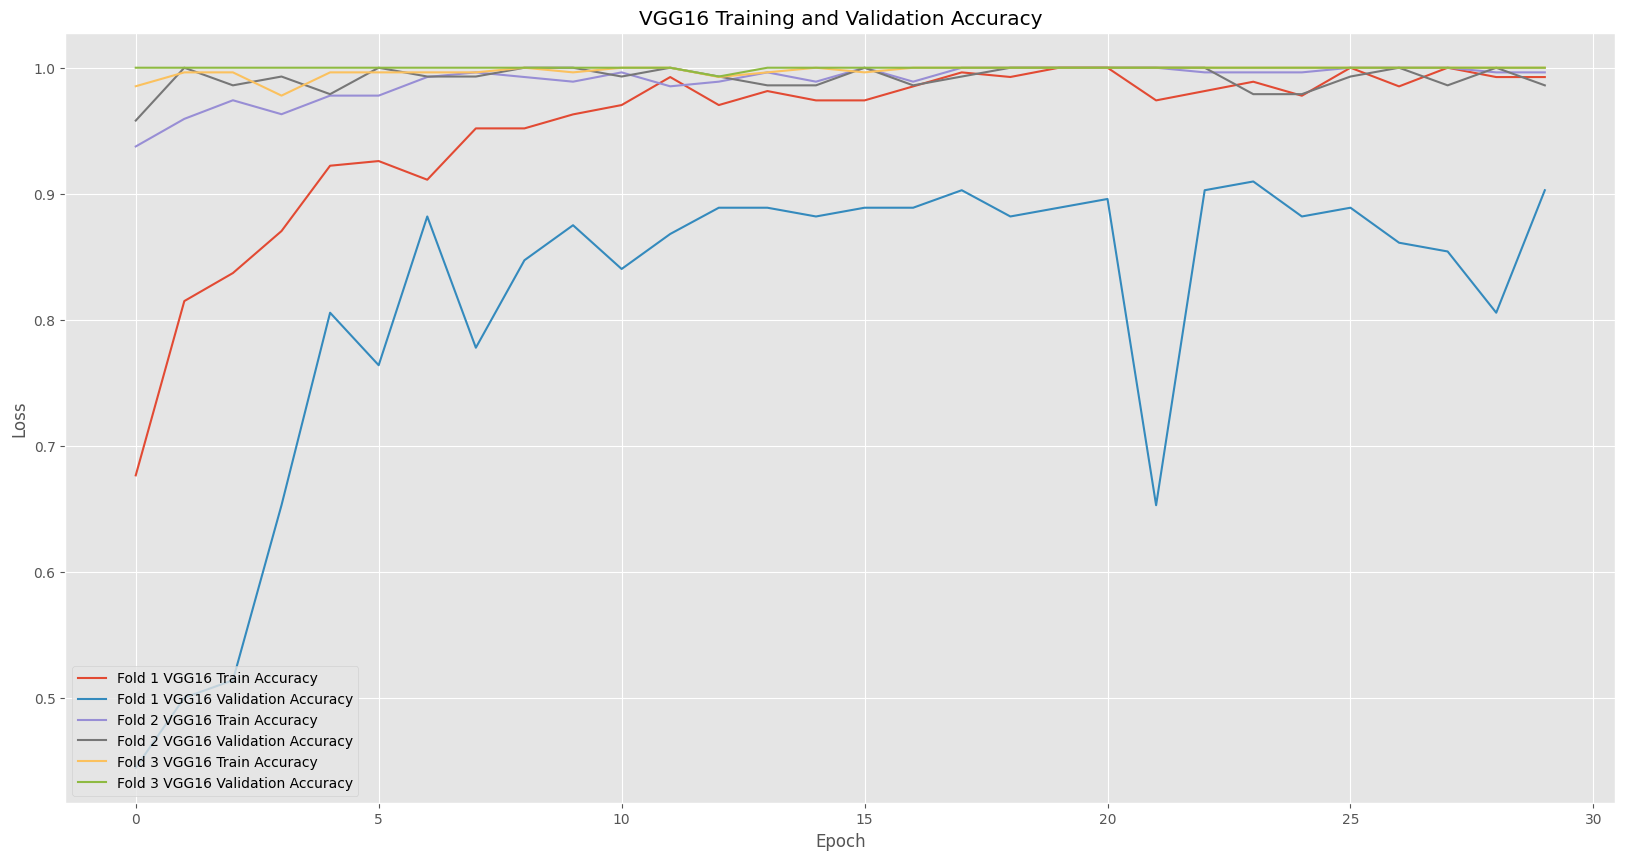

In [27]:
  # Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(vgg_train_accuracies[fold-1], label=f'Fold {fold} VGG16 Train Accuracy')
    plt.plot(vgg_val_accuracies[fold-1], label=f'Fold {fold} VGG16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.show()

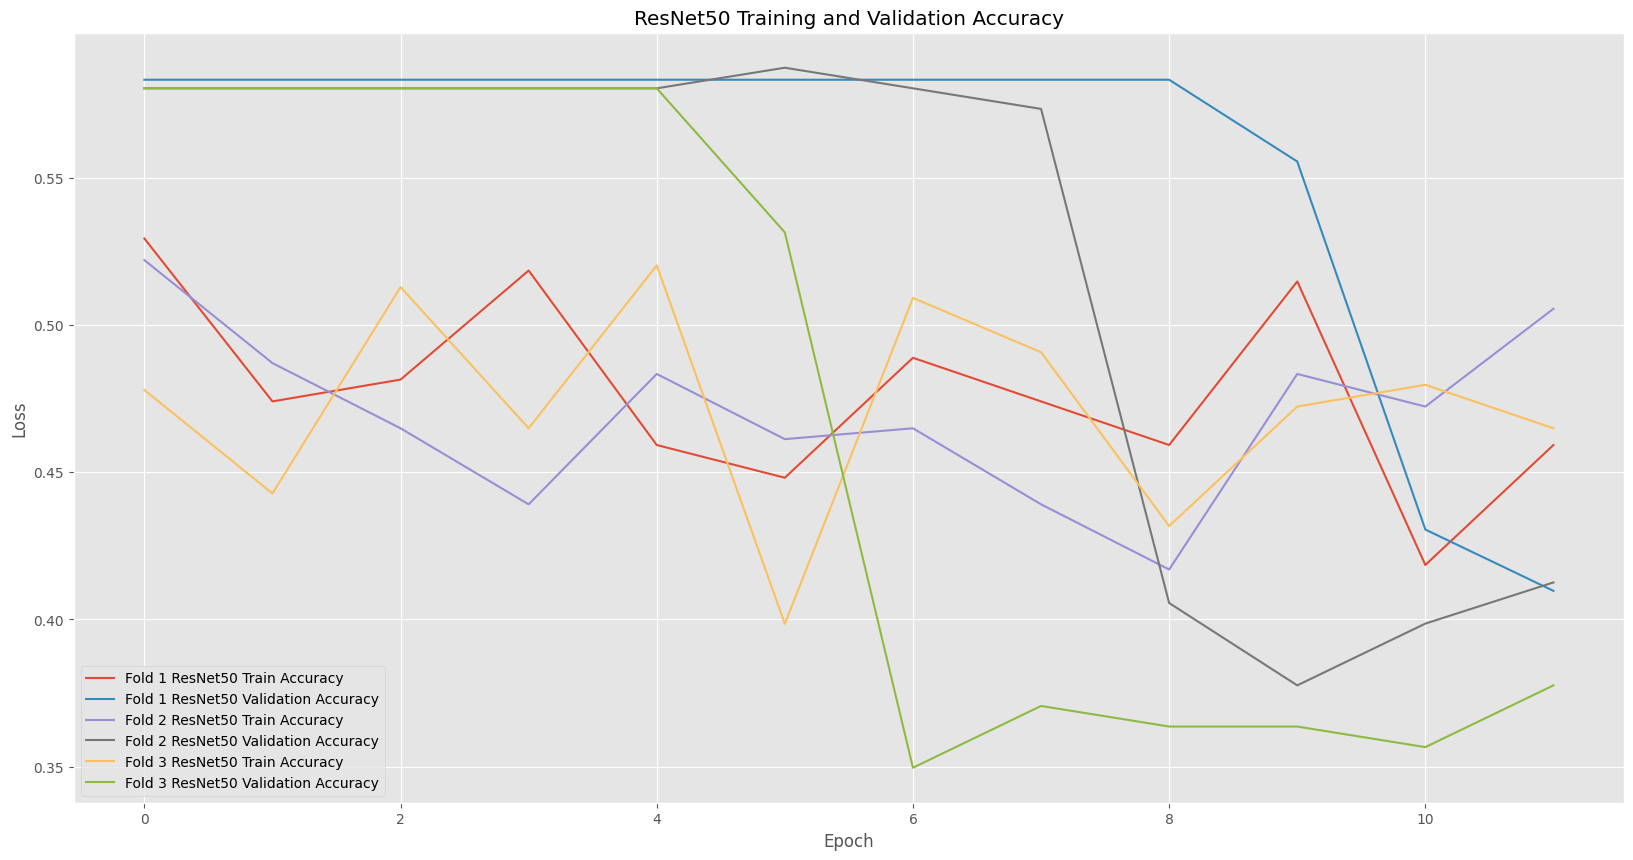

In [28]:
  # Plot the training and validation loss for each fold
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
for fold in range(1, num_folds+1):
    plt.plot(resnet_train_accuracies[fold-1], label=f'Fold {fold} ResNet50 Train Accuracy')
    plt.plot(resnet_val_accuracies[fold-1], label=f'Fold {fold} ResNet50 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Training and Validation Accuracy')
plt.legend(loc='lower left')
plt.show()

# 7. Model inferencing

In [14]:
from tensorflow.keras.preprocessing import image

# load best weights
cnn_model.load_weights("/content/drive/MyDrive/default_best_weights")

# load test image
testimg=image.load_img("/content/drive/MyDrive/dataset_8/covid/COVID-1018.png",target_size=(224, 224))

# resize and reshape image
testimg=image.img_to_array(testimg)
testimg=np.expand_dims(testimg,axis=0)
testimg= testimg/255.0

# perform logits prediction
logits=cnn_model.predict(testimg)
print(logits)

# determine the class '0' or '1'
predicted_classes = np.argmax(logits, axis=1)
print(f'what is predicted_classes {predicted_classes}')

# Assuming you have a list of class labels corresponding to your model's classes
class_labels = ['covid', 'normal']

# Map the predicted class indices to their respective class labels
predicted_labels = [class_labels[i] for i in predicted_classes]
print(predicted_labels)

1/1 [==============================] - 0s 221ms/step
[[0.860082  0.1399181]]
what is predicted_classes [0]
['covid']
